## 이번 강의 목표: 

* 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋이 필요한 이유 



* 교차검증의 이해 



* 분류기의 성능을 평가하는 여러가지 지표에 대한 이해 



* Pima Indians Diabetes 데이터셋에 대한 나이브 베이즈 분류기를 이용하여 위의 내용을 실습 

* 사용할 sklearn 모듈 및 메소드 ([참고:Classification metrics]https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics)  

        from sklearn.model_selection   import train_test_split,  cross_val_predict 
        from sklearn.naive_bayes       import GaussianNB  
        from sklearn.metrics           import accuracy_score,  precision_score,  recall_score,  f1_score,  confusion_matrix
        from sklearn.metrics           import average_precision_score
        from sklearn.metrics           import precision_recall_curve,  roc_curve,  roc_auc_score

* 복습이 필요한 넘파이 메소드  
> * `np.linspace` : ([API](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html?highlight=linspace#numpy.linspace))
> * `np.array` : ([API](https://numpy.org/doc/stable/reference/generated/numpy.array.html?highlight=array#numpy.array)) 
> * `np.zeros` : ([API](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html?highlight=zeros#numpy.zeros))  
> * `np.argmax` : ([API](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html?highlight=argmax#numpy.argmax))
> * `np.unique` : 반환되는 배열이 커지는 순서로 정렬됨에 주목 ([API](https://numpy.org/doc/stable/reference/generated/numpy.unique.html?highlight=unique))  
> * `np.random.uniform` : ([API](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html))


* 여기서 공부한 분류기의 성능에 대한 지표는 뒤에 배울 다양한 분류기(로지스틱 회귀, k-최근접 분류기, 트리기반 분류기 등)의 성능을 평가하고 비교할 때도 사용됨 

## PimaIndiansDiabetes 데이터셋에 대한 나이브 베이즈 분류기 복습

* 지난 시간에 훈련 데이터셋과 테스트 데이터셋을 나눌 때는 레이블의 불균형을 고려하지 않고 나누었지만, 실제로는 레이블의 비율을 유지하면서 데이터셋을 나누는 것이 필요함   
> * `sklearn.model_selection` 모듈의 `train_test_split`을 이용할 때, stratify 옵션을 이용 

* <span style="color:red">테스트 데이터셋에 대한 성능 평가는 최종적으로 선택된 모델에 대한 일반화된 성능을 예측하는 목적으로만 사용해야 함</span>  
> * 서로 다른 학습모델의 성능을 평가하기 위해서는 훈련 데이터셋을 다시 **훈련 데이터셋**과 **검증 데이터셋**으로 나누어서 <span style="color:red">검증 데이터셋에 대한 성능을 비교하거나</span>, **k겹 교차검증**을 이용하여 성능을 비교해야 함


* `sklearn.naive_bayes`모듈의 `GaussianNB`를 이용하여 예측을 할 때, 기본적으로 임곗값 0.5를 기준으로 판단  
> * 임곗값을 바꾸면서 모델의 (검증 데이터셋에 대한) 성능이 좋아지는지를 확인

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
# 데이터를 읽어들이고 고려할 특성을 선택 

data = pd.read_csv('./datasets/PimaIndiansDiabetes.csv')
data_subset = data.loc[:,['Blood Glucose', 'BMI', 'Class']]

In [4]:
# 데이터 정제

bg_mask = data_subset.loc[:,"Blood Glucose"]!=0
bmi_mask = data_subset.loc[:,"BMI"]!=0
clean_data_subset = data_subset[bg_mask & bmi_mask]

In [5]:
# 전체 샘플 중 레이블이 1인 샘플의 비율이 0.35, 0인 샘플의 비율이 0.65

(clean_data_subset.Class==1).sum() / len(clean_data_subset) 

0.35106382978723405

In [6]:
# 테스트 데이터셋 분리 (레이블의 비율을 고려하여 데이터셋 분리)

trainD, testD = train_test_split(clean_data_subset, test_size=0.2, random_state=20, stratify=clean_data_subset.Class)

In [7]:
(testD.Class==1).sum()/len(testD)

0.3509933774834437

In [8]:
(trainD.Class==1).sum()/len(trainD)

0.35108153078202997

In [9]:
X_train = trainD[['Blood Glucose', 'BMI']]
y_train = trainD['Class']
X_test = testD[['Blood Glucose', 'BMI']]
y_test = testD['Class']

## 교차검증을 이용하여 임곗값의 변화에 대해 분류기의 성능 (정확도) 비교

* 서로 다른 분류기의 성능을 비교하기 위해서는  
> 1. 훈련 데이터셋을 다시 훈련 데이터셋과 검증 데이터셋으로 나누고,  
> 2. 훈련 데이터셋으로 모델을 학습시킨 후,
> 3. (학습에 사용되지 않은) 검증 데이터셋에 대해 성능을 평가해야 함 

* 훈련 데이터셋의 샘플이 충분하지 않을 때는 k겹 교차검증을 이용 (주로 $k=5$, $k=10$을 이용)
> 1. 훈련 데이터셋 $D$를 비슷한 크기의 겹치지 않는 $k$부분 $D_1,\cdots,D_k$로 나누고, (단, $D=D_1\cup \cdots \cup D_k$) 
> 2. 각 $i=1,\cdots,k$에 대해, $D_i$를 제외한 나머지 데이터셋으로 학습한 모델을 이용하여 $D_i$에 대한 예측을 구함 
> 3. 결과적으로 각 샘플에 대해 깨끗한 예측(즉, 모델이 훈련하는 동안 보지 못했던 샘플에 대한 예측)이 이루어 짐 

* 위의 과정을 직접 구현하는 것이 복잡하지는 않지만, `sklearn.model_selection` 모듈의 `cross_val_predict`메소드를 이용 ([API](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html))  
> * 사용법: `cross.val_predict( 예측기, 입력 데이터, 레이블 데이터, cv=k값 지정, method= 반환되는 값의 종류를 문자열로 전달)`  
>> * 예측기가 `분류기`인 경우, 위의 옵션 중 `method`에 "predict"를 전달하면 분류기의 예측값이 반환되고, "predict_proba"를 전달하면 각 샘플 $\mathbf x$마다 가능한 레이블 $y$에 대해 $p(y|\mathbf x)$값의 배열이 반환됨  
>> * 예측기에 `predict_proba` 메소드가 없는 경우 `decision_function` 메소드를 이용 
> * 직접 구현할 때 참고 사항:  
>> * 샘플을 레이블별 나누고 랜덤하게 섞은 뒤, 각각 $k$개의 부분으로 나누어야 함  
>> * `sklearn.model_selection` 모듈의 `StratifiedKFold`를 이용하면 이 과정을 쉽게 해결할 수 있음 ([API](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratifiedkfold#sklearn.model_selection.StratifiedKFold))

In [10]:
# cross_val_predict 를 이용하여 임곗값에 따른 정확도 비교 

from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

classifier = GaussianNB()

In [11]:
y_val_probs = cross_val_predict(classifier, X_train, y_train, cv=5, method="predict_proba")

In [12]:
y_val_probs[:3]

array([[0.49850278, 0.50149722],
       [0.67687315, 0.32312685],
       [0.07795081, 0.92204919]])

In [13]:
y_val_prob1 = y_val_probs[:,1] # 샘플이 주어질 때, 레이블이 1이 될 확률을 y_train와 같은 index순으로 구함

In [14]:
thresholds = np.linspace(0,1,101)  # 0과 1을 포함하여 [0,1]을 20등분 
acc = []
for t in thresholds:
    y_val_pred = y_val_prob1 >= t
    acc.append(accuracy_score(y_train, y_val_pred))
best_threshold = thresholds[np.argmax(acc)]

In [15]:
print(f"정확도는 임곗값이 t={best_threshold}일 때 {acc[np.argmax(acc)]*100 :.2f}%")
print(f"임곗값이 0.5일 때 정확도는 {acc[list(thresholds).index(0.5)]*100 : .2f}%")

정확도는 임곗값이 t=0.64일 때 76.21%
임곗값이 0.5일 때 정확도는  74.88%


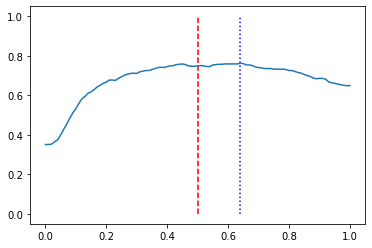

In [16]:
plt.plot(thresholds, acc)
plt.vlines(0.5, 0,1, colors='r',linestyles='dashed')
plt.vlines(0.64, 0,1, colors='b', linestyle='dotted')

## 분류기에 대한 다양한 성능 평가 1: 오차행렬

* 분류기의 성능을 평가하는 좋은 방법은 **오차행렬(confusion matrix)**를 조사하는 것: 기본적인 아이디어는 실제로는 클래스 A인 샘플이 클래스 B로 예측되는 횟수를 표로 나타내는 것
> * 행을 기준으로 실제 레이블(클래스)을 나열하고, 열을 기준으로 예측된 레이블을 나열  
> * 레이블의 종류가 $k$개이면 $k\times k$ 행렬이 만들어짐  
> * 레이블이 0(음성,negative), 1(양성,positive)인 경우 오차행렬은 다음과 같음 

    |    |(예측된) 음성|(예측된) 양성|
    |-|-|-|
    |(실제) 음성|TN  |FP  |
    |(실제) 양성|FN  |TP  |
>> * 실제 음성이고 음성으로 예측된 샘플의 개수를 TN (True Negative)  
>> * 실제 음성이고 양성으로 예측된 샘플의 개수를 FP (False Positive)  
>> * 실제 양성이고 음성으로 예측된 샘플의 개수를 FN (False Negative) 
>> * 실제 양성이고 양성으로 예측된 샘플의 개수를 TP (True Positive)

* TN을 구하는 것을 실제로 구현해보면, 오차행렬의 구현이 쉬움을 알 수 있음  
> * `sklearn.metrics` 모듈의 `confusion_matrix`를 이용

#### 앞에서 교차검증 방식으로 구한 y_val_pred(예측 레이블)과 y_train(실제 레이블)으로부터 오차행렬을 구현해보자. 
> * 임곗값 0.64를 이용하여 y_val_pred을 구하고, 이를 이용하여 오차행렬을 계산 

In [17]:
y_val_pred = (y_val_prob1 > best_threshold)

In [18]:
def my_confusion_matrix1(y_true, y_pred):
    tn = ((y_true==0) & (y_pred==0)).sum()
    fp = ((y_true==0) & (y_pred==1)).sum()
    fn = ((y_true==1) & (y_pred==0)).sum()
    tp = ((y_true==1) & (y_pred==1)).sum()
    return np.array([[tn, fp],[fn,tp]])

# y의 레이블 종류가 2개가 아닌 경우도 아래 코드를 조금만 수정하면 됨 
def my_confusion_matrix2(y_true, y_pred):  
    cf_mat = np.zeros((2,2), dtype=int)
    for i in range(2):
        for j in range(2):
            cf_mat[i,j] = ((y_true == i) & (y_pred == j)).sum()
    return cf_mat

In [19]:
my_confusion_matrix1(y_train, y_val_pred)

array([[365,  25],
       [118,  93]], dtype=int64)

In [20]:
my_confusion_matrix2(y_train, y_val_pred)

array([[365,  25],
       [118,  93]])

#### `sklearn.metrics` 모듈의 `confusion_matrix` 사용

In [21]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_train, y_val_pred)
cf_matrix

array([[365,  25],
       [118,  93]], dtype=int64)

## 분류기에 대한 다양한 성능 평가 2: 오차행렬의 해석

* 각 클래스별로 오분류된 정도를 파악하기 위해서는 행렬의 각 값을 대응되는 클래스의 총 개수로 나누어서 오분류 비율을 비교 

In [22]:
# 오차행렬의 해석을 위한 계산 

row_sums = cf_matrix.sum(axis=1, keepdims=True)  
# cf_matrix.sum(axis=1)와 같이 keepdims=False로 해도 아래 계산에서 broadcasting에 의해 문제 없음

norm_cf_matrix = cf_matrix / row_sums

# 양성은 굉장히 많이 틀림
norm_cf_matrix

array([[0.93589744, 0.06410256],
       [0.55924171, 0.44075829]])

## 분류기에 대한 다양한 성능 평가 3: 요약된 지표 - 정밀도(precision)와 재현율(recall)

* 양성(레이블 1) 예측의 정확도를 측정하는 **정밀도(precision)** 
$$\text{precision}= \dfrac{\text{TP}}{\text{TP}+\text{FP}}$$
> 문제점: 양성에 대한 확신이 가장 강한 한 개의 샘플에 대해서만 양성을 예측하고 나머지는 음성을 예측하는 분류기를 생각하면, 유용하지 않은 분류기이지만 정밀도는 $1$로 완벽  
> 정밀도의 문제점을 보완하기 위해 **재현율(recall)**이라는 지표와 함께 사용  



* **재현율**은 분류기가 정확하게 분류한 양성 샘플의 비율로 **민감도(sensitivity)**, **진짜 양성 비율(TPR:True Positive Rate)**라고도 함 
$$\text{recall} = \dfrac{\text{TP}}{\text{TP}+\text{FN}}$$  




* 정밀도와 재현율의 조화평균을 **$F_1$점수($F_1$score)**라 하는데, 정밀도와 재현율이 비슷한 분류기의 경우에 $F_1$점수가 높음 
$$F_1 = \dfrac{2\times\text{precision}\times \text{recall}}{\text{precision}+\text{recall}}$$  
> 상황에 따라 재현율을 다소 포기하더라도 정밀도를 높이는 것이 필요한 경우도 있고, 그 반대 경우도 있을 수 있음 (<span style="color:red"> 이론 연습문제 1, 2 </span> 참고)

* 정밀도와 재현율을 구하는 함수를 쉽게 구현할 수 있지만, `sklearn.metrics` 모듈에서 다음을 이용 
> * `precision_score` ([API](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score))  
> * `recall_score` ([API](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score))  
> * `f1_score` ([API](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score))

* 나이브 베이즈 분류기에서 주어진 샘플에 대한 레이블이 $1$일 확률 $p(1|\mathbf x)$을 임곗값과 비교하여 판별함수를 구현한다고 하자.  

> * 나이브 베이즈 분류기의 기본적인 판별함수는 임곗값 $0.5$를 사용하는 것으로 $p(1|\mathbf x)\ge p(0|\mathbf x)$일 때 레이블 $1$로 예측  


> * 임곗값에 따라 예측을 결정하기 위해서는 나이브 베이즈 분류기의 `predict` 메소드가 아닌 `predict_proba`를 이용하여 확률을 반환받고, 임곗값과 비교하여 레이블을 예측해야 함   


> * 일반적으로 정밀도를 높이면 재현율이 낮아지고 그 반대도 마찬가지인데, 이를 ** 정밀도/재현율 균형(trade off)**이라고 함   
>> * 임곗값을 크게 하면, 정밀도는 높아지면서 $1$에 가까워지고 재현율은 낮아지면서 $0$에 가까워짐  
>> * 임곗값을 작게 하면, 재현율은 높아지지만 정밀도는 낮아짐 
>> * 실제 구현을 할 때는 계산된 `predict_proba` 또는 `decision_funcion`로부터 계산되어진 서로 다른 값들을 임곗값으로 정함 (이 경우 가장 큰 임곗값에 대해 정밀도는 $1$이 되고, 재현율은 $0$에 가까운 값  
>> * `sklearn.metrics` 모듈의 `precision_recall-curve`를 이용하여 정밀도, 재현율, 임곗값을 구할 때, 정밀도와 재현율은 임곗값보다 1개의 값을 더 가짐 (정밀도 배열의 가장 마지막 값을 $1$, 재현율의 가장 마지막 값을 $0$으로 설정)

#### 임곗값에 따른 정밀도와 재현율의 변화를 직접 구현  

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

Text(0.5, 0, 'threshold')

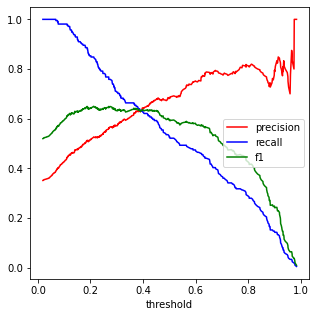

In [24]:
# 직접 구현 

thresholds_1 = np.unique(y_val_prob1)
precisions_1 = []
recalls_1 = []
f1s_1 = []

for t in thresholds_1:
    y_val_pred = (y_val_prob1 >= t)
    precisions_1.append(precision_score(y_train, y_val_pred))
    recalls_1.append(recall_score(y_train, y_val_pred))
    f1s_1.append(f1_score(y_train, y_val_pred))

plt.figure(figsize=(5,5))    
plt.plot(thresholds_1, precisions_1, c='r', label="precision")
plt.plot(thresholds_1, recalls_1, c='b', label="recall")
plt.plot(thresholds_1, f1s_1, c='g', label="f1")

plt.legend(loc="center right", fontsize=10)  
plt.xlabel("threshold", fontsize=10)         
    

In [25]:
thresholds_1[np.argmax(thresholds_1 >=0.5)]

0.5014972167017477

In [26]:
print(precisions_1[np.argmax(thresholds_1 >=0.5)])
print(recalls_1[np.argmax(thresholds_1 >=0.5)])

0.6851851851851852
0.5260663507109005


In [27]:
# 정밀도와 재현율이 같아지는 임곗값은?

pr_eq_t = np.argmax(np.array(precisions_1)- np.array(recalls_1)==0)
print(thresholds_1[pr_eq_t])
print(precisions_1[pr_eq_t])
print(recalls_1[pr_eq_t])

0.3912079171353838
0.6303317535545023
0.6303317535545023


#### `sklearn.metrics` 모듈의 `precision_recall-curve`를 이용하면 임곗값에 따른 정밀도와 재현율을 한꺼번에 얻을 수 있음 ([API](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html?highlight=precision_recall_curve#sklearn.metrics.precision_recall_curve))

In [28]:
from sklearn.metrics import precision_recall_curve

precisions_2, recalls_2, thresholds_2 = precision_recall_curve(y_train, y_val_prob1)

Text(0.5, 0, 'threshold')

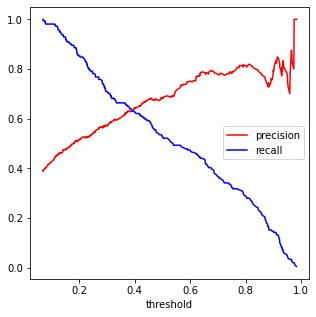

In [29]:
plt.figure(figsize=(5,5))
plt.plot(thresholds_2, precisions_2[:-1], c='r', label="precision")
plt.plot(thresholds_2, recalls_2[:-1], c='b', label="recall")

plt.legend(loc="center right", fontsize=10)  
plt.xlabel("threshold", fontsize=10) 

In [30]:
print(f"len(thresholds_2)={len(thresholds_2)}, len(precisions_2)={len(precisions_2)}")

len(thresholds_2)=539, len(precisions_2)=540


## 분류기에 대한 다양한 성능 평가 4: 좋은 정밀도/재현율 균형을 선택하는 방법-PR곡선

* 재현율에 대한 정밀도 곡선을 그려서 문제의 성격에 맞는 임계값을 선택 (이 곡선을 **PR 곡선(precision-recall curve)**이라고 함)


* PR곡선이 대체로 매끄럽게 그려진 경우, 일반적으로 정밀도가 급격하게 떨어지기 직전을 정밀도/재현율 균형으로 선택 

<img src=".\images\week5\pr_curve.png" width="400">

* 서로 다른 두 모델을 비교하여 선택하는 상황에서는 PR 곡선 아래의 넓이가 큰 모델이 좋은 모델: PR 곡선의 넓이를 구할 때 `sklearn.metric` 모듈의 `average_precision_score`를 이용 ([API](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score))

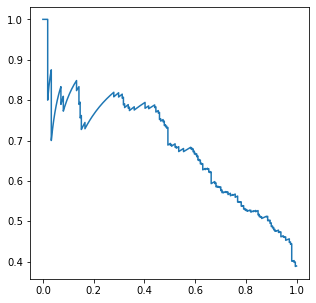

In [31]:
plt.figure(figsize=(5,5))
plt.plot(recalls_2, precisions_2)

#### PimaIndiansDiabetes 데이터셋에 대한 PR 곡선을 보면, 이 경우 나이브 베이즈 분류기의 한계를 보여줌 

* 한계의 원인: 나이브 베이즈 가정의 문제, 조건부 확률함수로 정규분포가 적당하지 않은 가능성, 특성벡터를 정하는 속성의 개수를 너무 작게 잡은 것에 대해 하나씩 검토해 볼 수 있음 


* 가장 이상적인 PR 곡선은 $(0,1)$과 $(1,0)$을 지나는 위로 볼록한 곡선이 $(1,1)$ 근처에 가깝게 위치하는 곡선: 이 경우 곡선의 넓이는 $1$에 가까움 



* 위 PR곡선에 대한 넓이를 구하면 $0.68$

In [32]:
from sklearn.metrics import average_precision_score

print(f"PR 곡선 아래의 넓이는 {average_precision_score(y_train, y_val_prob1) : 0.2f}")

PR 곡선 아래의 넓이는  0.68


## 분류기에 대한 다양한 성능 평가 5: ROC 와 AUC

* **ROC(Receiver Operating Characteristic) 곡선**은 이진 분류기(레이블이 두 가지)의 성능을 평가하기 위해 사용되는 곡선으로 **거짓 양성 비율(FPR:False Positive Rate)**에 대한 **진짜 양성 비율(TPR:True Positive Rate)**을 나타낸 곡선  

> * 진짜 양성 비율은 재현율의 다른 이름 

> * **거짓 양성 비율**은 양성으로 잘못 분류된 음성 샘플의 비율. 이는 $1$에서 음성으로 정확하게 분류한 음성 샘플의 비율인 **진짜 음성 비율 (TNR)**을 뺀 값 


$$\text{FPR}= \dfrac{\text{FP}}{\text{TN}+\text{FP}} = 1-\dfrac{\text{TN}}{\text{TN}+\text{FP}}=1-\text{TNR}$$  
> * TNR을 **특이도(specificity)**라고도 함 (따라서 ROC 곡선은 `민감도(재현율)`에 대한 `1-특이도`의 그래프 

> `sklearn.metrics` 모듈의 `roc_curve`함수를 사용하면 여러 임곗값에 대한 TPR과 FPR을 동시에 구할 수 있음 

* ROC 곡선 아래의 면적 **AUC(Area Under the Curve)**을 측정하면 분류기들을 비교할 수 있음  

> * 완변한 분류기는 ROC의 AUC가 1이고, 완전히 랜덤한 분류기에 대한 AUC는 0.5  

> * `sklearn.metrics` 모듈의 `roc_auc_score`함수를 이용하면 AUC를 구할 수 있음

* ROC에 대한 AUC의 확률적 의미:  

> * 랜덤하게 뽑은 양성 샘플의 score(우리 예의 경우에는 레이블이 1이 될 확률)가 랜덤하게 뽑은 음성 샘플의 score보다 클 확률 
<img src=".\images\week5\roc_auc.png" width="350">

#### ROC, AUC의 계산 

* `sklearn.metrics` 모듈의 `roc_curve` 함수를 사용하여 임곗값과 임곗값에 대한 FPR, TPR 계산  


* `sklearn.metrics` 모듈의 `roc_auc_score` 함수를 사용하여 AUC 값 계산 

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

Text(0.6, 0.2, 'AUC= 0.81')

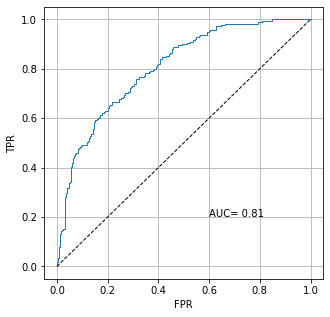

In [34]:
auc = roc_auc_score(y_train, y_val_prob1)

fpr, tpr, thresholds = roc_curve(y_train, y_val_prob1)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, linewidth=1)
plt.plot([0,1], [0,1], 'k--',linewidth=1)
plt.grid(True)
plt.xlabel("FPR", fontsize=10)
plt.ylabel("TPR", fontsize=10)
plt.text(0.6,0.2, f"AUC={auc : .2f}")


## 분류기에 대한 다양한 성능 평가 6: ROC곡선과 PR곡선 

* 일반적으로 양성 클래스가 아주 드물거나 거짓음성보다 거짓양성이 더 중요한 의미를 가질 때는 PR 곡선을 사용하고, 그 외에는 ROC곡선을 사용   



* 예를 들어, 앞에서 살펴본 PimaIndiansDiabete 데이터셋의 경우에 양성 샘플의 개수가 음성 샘플에 비해 적기 때문에 ROC곡선과 AUC 값은 그다지 나빠 보이지 않지만, PR곡선을 보면 개선의 여지가 많이 보이는 것을 알 수 있음 


## 코드 작성 연습문제 

1. 샘플에 대한 실제 레이블($1$ 또는 $0$)을 담고 있는 `y_true`와 레이블이 $1$이 될 확률을 담고 있는 `y_prob`를 입력으로 하여 ROC 곡선을 그려주는 함수를 다음 조건에 맞게 작성하시오.  
> * `sklearn` 모듈의 메소드들은 사용하지 않고, Numpy만을 이용하여 작성하시오.
> * 각 축에 FPR, TPR를 표시
> * 전체 그림의 size는 (3,3)이 되도록 설정 


2. 랜덤하게 1 또는 0을 반환하는 판별함수를 사용하는 분류기를 완전한 랜덤 분류기라 한다. 랜덤 분류기의 예측은 `np.random.uniform(0,1,size=샘플개수)`를 이용하여 구현할 수 있다. 위 예제에서 사용한 `y_val`에 대한 예측값을 랜덤 분류기로 구하고, 랜덤 분류기에 대한 ROC 곡선을 그리시오. 


## 이론 연습문제  

1. 아동에게 유용한 동영상을 걸러내는 분류기의 경우에 재현율과 정밀도 중 어떤 것이 더 중요한지 판단하시오. (이 분류기의 예측에서 레이블 1(양성)은 유용한 동영상, 레이블 0(음성)은 비교육적인 동영상을 뜻한다.  



2. 감시카메라를 통해 침입자를 걸러내는 분류기를 학습시킨다고 할 때, 재현율과 정밀도 중 어떤 것이 더 중요한지 판단하시오. (이 분류기의 예측에서 레이블 1(양성)은 침입자를 뜻한다)


3. 임곗값에 대해 정밀도와 재현율을 그래프로 그릴 때, 임곗값이 $0.8$과 $0.9$사이에 있을 때 정밀도의 그래프가 재현율의 그래프에 비해 더 울퉁불퉁한 이유를 설명하시오. 


4. 아래 그림은 0부터 9까지의 숫자가 적힌 그림샘플에 대해 5를 양성으로 분류하는 어떤 분류기의 판별함수 값을 수직선 상에 표시한 것이다. 
<img src=".\images\week5\pr_exer.png" width="350">   


4-1) 임곗값1, 임곗값2일 때의 정밀도와 재현율을 각각 구하시오.   


4-2) 일반적으로 임곗값이 커지면 정밀도는 높아지지만, 항상 성립하는 것은 아니다(위 연습문제 3 참고). 위의 그림에서 이를 설명할 수 있는 임곗값의 위치를 찾고 설명하시오. 